In [65]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# Focusing on Total Yards of both teams and the score of said team, pairing down
# to a single table with just the columns we need. Swap around names to be more
# readable

df = pd.read_csv('2019_NFL_COMBINE - 2019_NFL_COMBINE.csv')
nfl_t1_df = df[['Tm', 'TotYd', 'Opp.1']]
nfl_t2_df = df[['Opp.1', 'TotYd.1', 'TotYd']]
nfl_t2_df = nfl_t2_df.rename(columns = {'Opp.1': 'Tm'})
nfl_t2_df = nfl_t2_df.rename(columns = {'TotYd': 'temp'})
nfl_t2_df = nfl_t2_df.rename(columns = {'TotYd.1': 'TotYd'})
nfl_t2_df = nfl_t2_df.rename(columns = {'temp': 'Opp.1'})
nfl_df = nfl_t1_df.append(nfl_t2_df, ignore_index = True)
nfl_df = nfl_df.rename(columns = {'Tm': 'Score'})
nfl_df = nfl_df.rename(columns = {'TotYd': 'Yards_1'})
nfl_df = nfl_df.rename(columns = {'Opp.1': 'Yards_2'})
nfl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Score    1036 non-null   int64
 1   Yards_1  1036 non-null   int64
 2   Yards_2  1036 non-null   int64
dtypes: int64(3)
memory usage: 24.4 KB


In [66]:
# OLS

Y = np.log1p(nfl_df['Score'])
X = nfl_df[['Yards_1', 'Yards_2']]
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 37)
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

lrm = LinearRegression()
lrm.fit(X_train, y_train)
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.359024152341499
-----Test set statistics-----
R-squared of the model in the test set is: 0.39026406610418574
Mean absolute error of the prediction is: 0.31600076088991497
Mean squared error of the prediction is: 0.21702992542136415
Root mean squared error of the prediction is: 0.4658647072073223
Mean absolute percentage error of the prediction is: inf


In [68]:
# KNN

knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(nfl_df.Yards_1)
Y = nfl_df.Score
knn.fit(X, Y)

KNeighborsRegressor(n_neighbors=10)

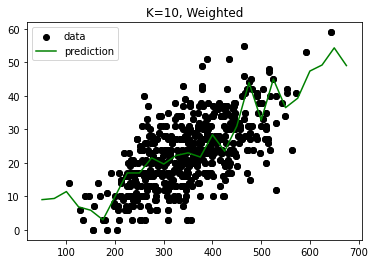

In [70]:
# Run the same model, this time with weights
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(nfl_df.Yards_1)
Y = nfl_df.Score
knn_w.fit(X, Y)

T = np.arange(50, 700, 25)[:, np.newaxis]
Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

In [71]:
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: 0.44 (+/- 0.04)
Weighted Accuracy: 0.62 (+/- 0.08)


In [ ]:
# The dataset being worked with has the score and game data for a season of nfl play. The Focus for this lesson was the score
# of Team A and the total yards of both Team A and B. With the goal of predicting a Teams scored points based off the yardage
# of either Team A or both Teams.

# Ols does not produce great results with only 35% accuracy. This is not particularly surprising given that we are only using 
# two variables for this case. Specifically two that are so similar to one another. Would likely use additional values if we 
# are not strictly looking to compare knn and ols.

# Knn produced a 62% accruacy when weighted. The model seems to function better than ols when dealing with a smaller set of 
# variables, specifically in the case of looking for correlation between values and then predicting based off those values.